In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import TruncatedSVD
import hdbscan
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import OPTICS

In [2]:
train = sparse.load_npz("train.npz")
data = pd.DataFrame.sparse.from_spmatrix(train)

### Здравствуйте! В данном ноутбуке попытаюсь показать ход своих мыслей при решении задачи. Сразу признаюсь - у меня мало что получилось, но я пытался)

In [3]:
data.shape

(14590, 77888)

In [4]:
type(data)

pandas.core.frame.DataFrame

In [5]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,77878,77879,77880,77881,77882,77883,77884,77885,77886,77887
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


В следущих нескольких ячейках будет попытка снизить размерность (довольно варварским способом), просто взяв топ 10000 столбцов, у которых наибольшая дисперсия, а остальные - дроп. Метод PCA у меня не сработал, так как память отказывается хранить такой большой numpy array

In [12]:
data_densed = data.sparse.to_dense()

In [13]:
# Нахождение дисперсии для каждого столбца
variance_per_column = data_densed.var()

# Сортировка столбцов по убыванию дисперсии
sorted_columns = variance_per_column.sort_values(ascending=False)

# Выбор топ n столбцов
n = 10000
top_n_columns = sorted_columns.head(n)

# Оставление только топ n столбцов в DataFrame
data_top_n = pd.DataFrame(data[top_n_columns.index])

print(data_top_n)

          58591     44603     66053     41691     38281     15531     7719   \
0             0         0         0         0         0         0         0   
1             0         0  0.022221         0         0         0  0.024052   
2             0         0         0         0         0         0         0   
3             0  0.043203  0.019456   0.07474         0  0.047673   0.02106   
4             0  0.042362         0         0         0         0  0.082599   
...         ...       ...       ...       ...       ...       ...       ...   
14585  0.144568  0.062361         0         0         0         0         0   
14586         0  0.014924  0.094095  0.034425  0.022464         0  0.058199   
14587         0         0  0.062257         0         0         0         0   
14588         0  0.031332   0.02822         0         0  0.069146  0.030545   
14589   0.02437  0.015768  0.014202         0   0.04747         0  0.015373   

          3911      46586     20592  ...  62745  46

In [14]:
data_top_n.shape

(14590, 10000)

In [15]:
data_top_n

,58591,44603,66053,41691,38281,15531,7719,3911,46586,20592,...,62745,46728,55527,20311,4068,55932,43052,1627,28945,27361
0,0,0,0,0,0,0,0,0.041522,0,0.035696,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0.022221,0,0,0,0.024052,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0.038937,0,0.033474,...,0,0,0,0,0,0,0,0,0,0
3,0,0.043203,0.019456,0.07474,0,0.047673,0.02106,0,0.021699,0.066815,...,0,0,0,0,0,0,0,0,0,0
4,0,0.042362,0,0,0,0,0.082599,0,0.042554,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14585,0.144568,0.062361,0,0,0,0,0,0,0.031322,0,...,0,0,0,0,0,0,0,0,0,0
14586,0,0.014924,0.094095,0.034425,0.022464,0,0.058199,0.017898,0.044975,0.046161,...,0,0,0,0,0,0,0,0,0,0
14587,0,0,0.062257,0,0,0,0,0,0.034717,0,...,0,0,0,0,0,0,0,0,0,0
14588,0,0.031332,0.02822,0,0,0.069146,0.030545,0,0.031473,0,...,0,0,0,0,0,0,0,0,0,0


## Попробуем обучить с помощью KMeans

In [30]:
kmeans = KMeans(n_clusters=5)

In [31]:
kmeans.fit(data_top_n)
# kmeans.labels_

/opt/anaconda3/envs/work/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5)

Посмотрим на распределение кластеров

<Axes: ylabel='Count'>

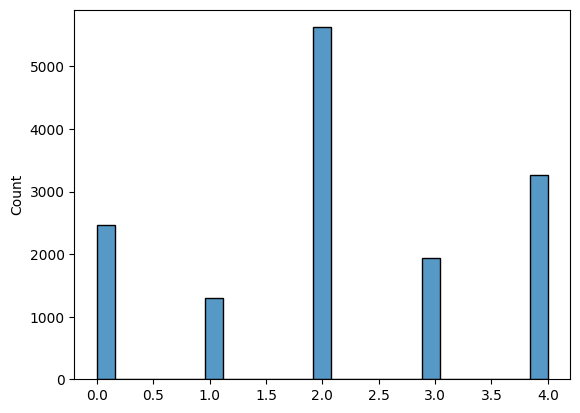

In [32]:
labels = kmeans.labels_
sns.histplot(kmeans.labels_)

Сформируем ответ

In [33]:
ans = pd.DataFrame()
ans['ID'] = [i for i in range(len(labels))]
ans['TARGET'] = labels

In [34]:
ans.head()

,ID,TARGET
0,0,2
1,1,2
2,2,4
3,3,0
4,4,4


In [36]:
ans.to_csv('ans14.csv')

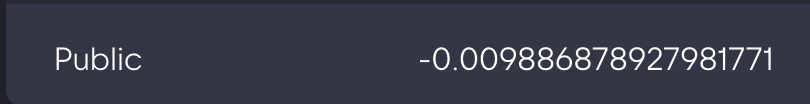

Как видим - ничего не вышло :(
Оно и логично - во-первых, мы не знаем сколько кластеров, во-вторых, KMeans рандомно выбирает центроиды и, видимо, выбрал не очень удачно

Попробуем плотностные методы

P.S. Этот метод в конечном итоге оказался лучшим, я просто несколько раз попробовал обучать модель и в силу рандомности выбора центроидов получились метрики получше, причем лучше, чем на всех других моделях далее

In [ ]:
model_hd = hdbscan.HDBSCAN().fit(data_top_n)
labels_hd = model_hd.labels_

In [16]:
set(labels_hd)


{-1, 0, 1}

/var/folders/jk/wmbjw1_d1tlbkns604pznpfr0000gn/T/ipykernel_19646/861856265.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(labels_hd)


<Axes: ylabel='Density'>

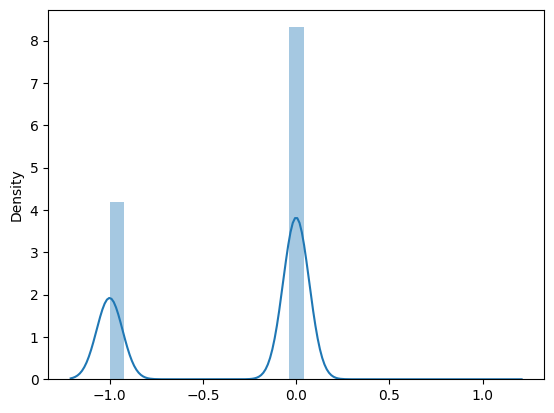

In [17]:
sns.distplot(labels_hd)

Получилось 3 кластера. но по графику будто бы 2

In [61]:
ans_hd = pd.DataFrame()
ans_hd['ID'] = [i for i in range(len(labels_hd))]
ans_hd['TARGET'] = labels_hd

In [64]:
ans_hd.head()

,ID,TARGET
0,0,-1
1,1,0
2,2,-1
3,3,0
4,4,-1


In [65]:
ans_hd.to_csv('ans2_hd.csv')

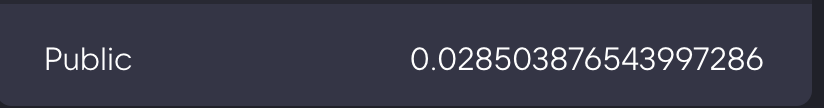

Все еще не очень - пробуем дальше

In [70]:
dbscan = DBSCAN().fit(data)
dbscan.labels_

array([-1, -1, -1, ..., -1, -1, -1])

In [71]:
set(dbscan.labels_)

{-1}

При таких параметрах dbscan выдает вообще 1 кластер, позже попробую поиграться с параметрами

In [4]:
sc = SpectralClustering(n_clusters=2)

In [ ]:
sc.fit(data)

In [21]:
set(sc.labels_)

{0, 1}

/var/folders/jk/wmbjw1_d1tlbkns604pznpfr0000gn/T/ipykernel_19646/3460582057.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sc.labels_)


<Axes: ylabel='Density'>

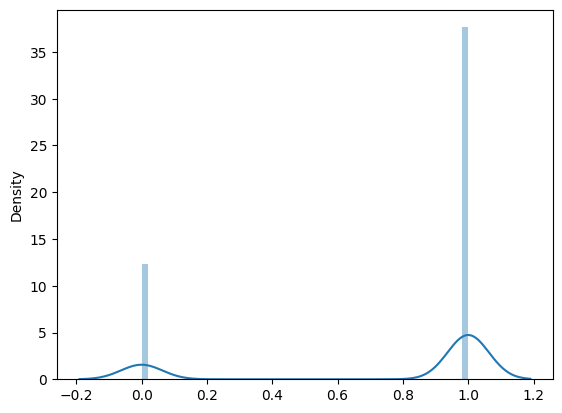

In [22]:
sns.distplot(sc.labels_)

In [25]:
sc2 = SpectralClustering(n_clusters=3).fit(data)

/var/folders/jk/wmbjw1_d1tlbkns604pznpfr0000gn/T/ipykernel_19646/361073707.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sc2.labels_)


<Axes: ylabel='Density'>

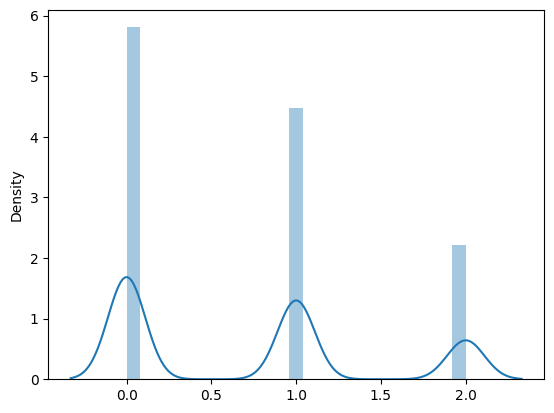

In [26]:
sns.distplot(sc2.labels_)

/var/folders/jk/wmbjw1_d1tlbkns604pznpfr0000gn/T/ipykernel_19646/1588402249.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sc3.labels_)


<Axes: ylabel='Density'>

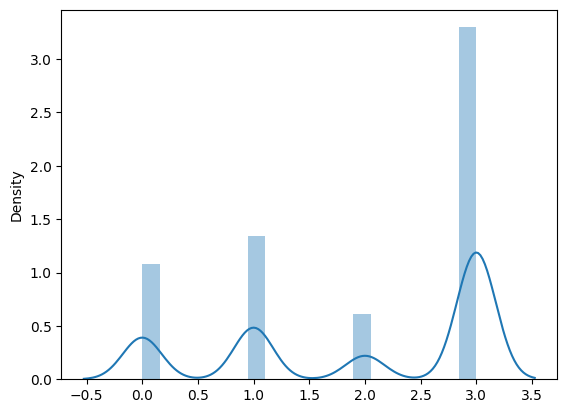

In [27]:
sc3 = SpectralClustering(n_clusters=4).fit(data)
sns.distplot(sc3.labels_)

In [ ]:
sc4 = SpectralClustering(n_clusters=5).fit(data_top_n)
sns.distplot(sc4.labels_)

In [30]:
ans_sc = pd.DataFrame()
ans_sc['ID'] = [i for i in range(len(sc.labels_))]
ans_sc['TARGET'] = sc.labels_
ans_sc.to_csv('ans3.csv')

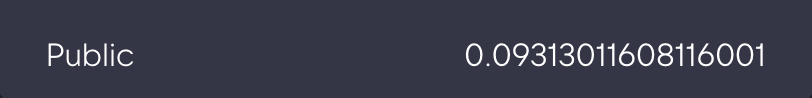

Это 2 кластера

In [31]:
ans_sc2 = pd.DataFrame()
ans_sc2['ID'] = [i for i in range(len(sc2.labels_))]
ans_sc2['TARGET'] = sc2.labels_
ans_sc2.to_csv('ans4.csv')

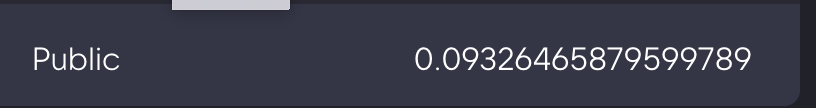

Это 3 кластера

In [32]:
ans_sc3 = pd.DataFrame()
ans_sc3['ID'] = [i for i in range(len(sc3.labels_))]
ans_sc3['TARGET'] = sc3.labels_
ans_sc3.to_csv('ans5.csv')

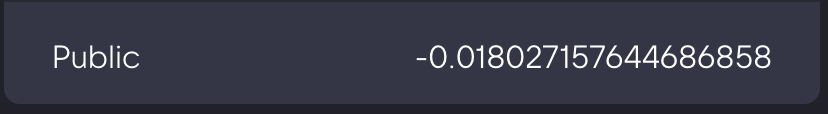

Это 4 кластера, стало еще хуже

In [33]:
ans_sc4 = pd.DataFrame()
ans_sc4['ID'] = [i for i in range(len(sc4.labels_))]
ans_sc4['TARGET'] = sc4.labels_
ans_sc4.to_csv('ans6.csv')

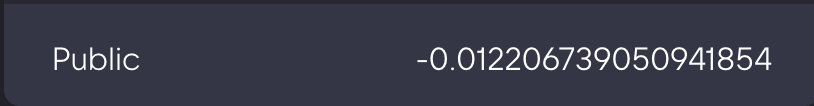

Это 5 кластеров, тоже плохо

In [ ]:
sc5 = SpectralClustering(n_clusters=6).fit(data)
sns.distplot(sc5.labels_)

Здесь снова попытки снизить размерность

In [32]:
svd = TruncatedSVD(n_components=1000)
reduced_data = pd.DataFrame(svd.fit_transform(data))

In [33]:
reduced_data.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.091196,0.001533,-0.023271,-0.044381,0.020554,-0.020416,-0.012325,-0.004180,0.027998,0.000091,...,-0.008724,0.040690,-0.025221,0.004386,0.025295,-0.008490,-0.032198,-0.004815,-0.000664,0.015681
1,0.090783,0.008813,-0.037615,-0.026222,0.011827,-0.005744,0.008526,-0.008063,0.034072,0.000471,...,-0.019326,-0.012181,-0.022135,0.006610,0.008709,-0.026680,0.006154,-0.012177,0.008311,0.004453
2,0.082608,0.003506,-0.019689,0.002238,-0.029184,-0.009877,0.005093,0.033191,-0.003287,0.033594,...,0.023939,0.004300,0.009672,0.004073,-0.047614,-0.017246,0.005099,-0.004958,-0.015012,-0.020411
3,0.173664,-0.015790,0.053503,-0.001740,-0.097585,0.007493,0.049974,0.043830,0.037543,0.054843,...,-0.007745,-0.018178,-0.019515,0.006089,-0.005519,-0.004594,0.014165,-0.004530,-0.014350,0.010575
4,0.100689,0.024296,-0.019660,0.003220,-0.028531,0.030929,-0.000093,-0.031040,-0.020463,0.038559,...,-0.025697,-0.022170,0.002106,0.005408,0.002233,0.000588,-0.011982,0.014029,0.032041,0.023179


Здесь я подумал о нормализации данных - ничего хорошего по итогу из этого не аышло

In [34]:
scaler = StandardScaler()
reduced_scaled_data = pd.DataFrame(scaler.fit_transform(reduced_data))

In [37]:
reduced_scaled_data.describe().T

,count,mean,std,min,25%,50%,75%,max
0,14590.0,2.164258e-15,1.000034,-2.596795,-0.713439,-0.226286,0.522710,6.572040
1,14590.0,-1.558421e-16,1.000034,-3.720440,-0.491020,0.051639,0.591513,4.101378
2,14590.0,4.207738e-16,1.000034,-3.778562,-0.695794,-0.052338,0.645203,3.838322
3,14590.0,-4.675264e-16,1.000034,-3.463811,-0.627135,-0.132380,0.420657,5.080083
4,14590.0,1.402579e-16,1.000034,-6.013362,-0.531713,0.051797,0.559020,6.564122
...,...,...,...,...,...,...,...,...
995,14590.0,1.314918e-17,1.000034,-3.573539,-0.664039,0.002155,0.663485,4.608258
996,14590.0,-1.363619e-17,1.000034,-3.899019,-0.666419,0.020424,0.661764,4.038210
997,14590.0,2.337632e-17,1.000034,-3.583806,-0.664363,-0.005504,0.667553,3.962044
998,14590.0,-2.435033e-19,1.000034,-3.663837,-0.663002,0.011277,0.662844,4.084837


/opt/anaconda3/envs/work/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


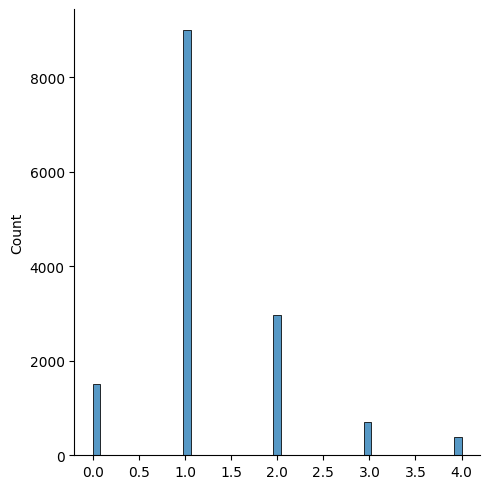

In [17]:
kmeans.fit(reduced_data)
sns.displot(kmeans.labels_)

In [18]:
ans_km2 = pd.DataFrame()
ans_km2['ID'] = [i for i in range(len(kmeans.labels_))]
ans_km2['TARGET'] = kmeans.labels_
ans_km2.to_csv('ans7.csv')

/var/folders/jk/wmbjw1_d1tlbkns604pznpfr0000gn/T/ipykernel_21053/3866262776.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(model_hd2.labels_)


<Axes: ylabel='Density'>

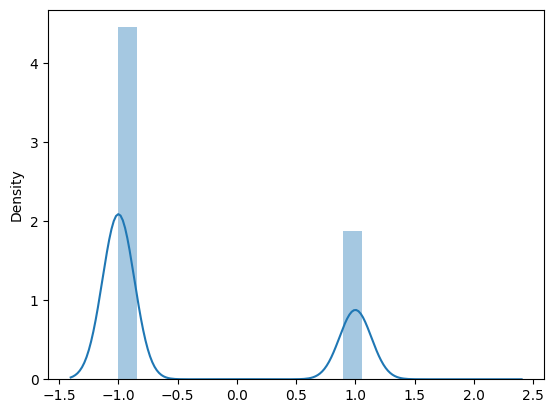

In [19]:
model_hd2 = hdbscan.HDBSCAN().fit(reduced_data)
sns.distplot(model_hd2.labels_)

In [20]:
ans_hd2 = pd.DataFrame()
ans_hd2['ID'] = [i for i in range(len(model_hd2.labels_))]
ans_hd2['TARGET'] = model_hd2.labels_
ans_hd2.to_csv('ans9.csv')

Здесь попробовал использовать следующую модель - GaussianMixture, метрики особо не улучшились

In [ ]:
gm = GaussianMixture(n_components=5).fit(data_top_n.sparse.to_dense())

In [29]:
labels_gm = gm.predict(reduced_data)

/var/folders/jk/wmbjw1_d1tlbkns604pznpfr0000gn/T/ipykernel_21053/743371218.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(labels_gm)


<Axes: ylabel='Density'>

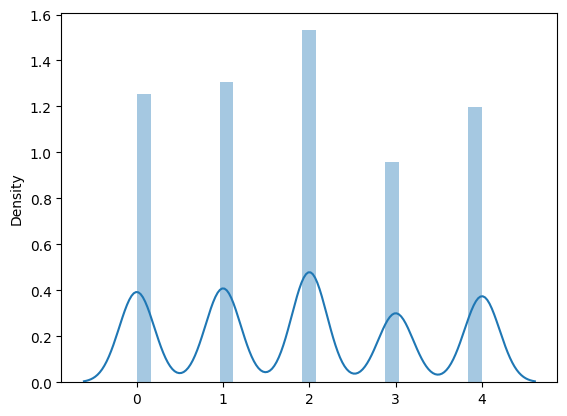

In [30]:
sns.distplot(labels_gm)

In [31]:
ans_gm = pd.DataFrame()
ans_gm['ID'] = [i for i in range(len(labels_gm))]
ans_gm['TARGET'] = labels_gm
ans_gm.to_csv('ans10.csv')

In [52]:
gm_scaled = GaussianMixture(n_components=3).fit(reduced_data)

/var/folders/jk/wmbjw1_d1tlbkns604pznpfr0000gn/T/ipykernel_21053/543358494.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(labels_gm_sc)


<Axes: ylabel='Density'>

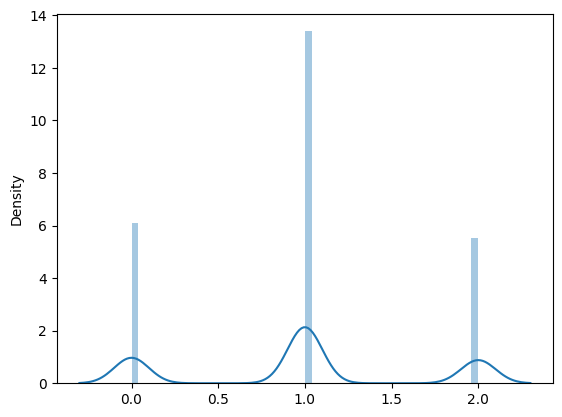

In [54]:
labels_gm_sc = gm_scaled.predict(reduced_data)
sns.distplot(labels_gm_sc)

Вот здесь как раз попытки сделать понижение через PCA

In [14]:
# Применение PCA для снижения размерности до 2
pca = PCA(n_components=100)
principal_components = pca.fit_transform(dense_data)

Далее я предпринял попытки для подбора гиперпараметров dbscan, в каких-то случаях выдавал решение нв 3 кластера, однако метрики все равно плохие

In [ ]:
for eps in [0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    for min_samples in range(5, 25):
        result = []
        dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(data_top_n)
        labels_opt = dbscan.labels_
        if len(set(labels_opt)) <= 5 and len(set(labels_opt)) >= 3:
            result.append((eps, min_samples, set(labels_opt)))
result

In [14]:
dbscan = DBSCAN(eps=0.3, min_samples=20, metric='cosine').fit(data_top_n)
labels_opt = dbscan.labels_

In [15]:
labels_opt

array([-1, -1, -1, ..., -1, -1, -1])

In [37]:
np.unique(labels_opt)

array([0, 1, 2])

In [38]:
ans_db = pd.DataFrame()
ans_db['ID'] = [i for i in range(len(labels_opt))]
ans_db['TARGET'] = labels_opt
ans_db.to_csv('ans_db3.csv')

## Выводы
В данной домашке я попытался кластеризовать точки по разреженной матрице. Честно признаться, результом я не доволен, так как метрики меня не удовлетворили и все эвристики, что я пробовал не сработали, а лучший результат получился на банальном k-means, который работает через раз.